In this notebook we show the capability for horsetail matching to deal with mixed uncertainties. Mixed uncertainties refers to when some of the uncertain parameters cannot be assigned probability distributions (for example they are due to a lack of knowledge, and so we have no data on which to base a distribution) and are instead represented with an interval.


As before we start by importing the modules we need and creating uncertain parameters. 
Horsetail matching allows uncertainties to be defined in two ways...

The simplest is using the built in UncertainParameter class and child classes.

If more flexibility is required, then a parameter can also be described by a function that returns a set of samples of this uncertain parameter.

These alternatives are illustrated below:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from horsetailmatching import UniformParameter, IntervalParameter, HorsetailMatching

u_prob = UniformParameter(lower_bound=-1, upper_bound=1)

n_samples = 500
def u_prob_alternative():
    return np.random.uniform(-1, 1, n_samples)

u_int = IntervalParameter(lower_bound=-1, upper_bound=1)

Then we can setup the horsetail matching object, using TP2 from the demo problems as our quantity of interest. Recall this is a fuction that takes two inputs: values of the design variables, x, and values of the uncertain parameters, u, and returns the quantity of interest, q. 

Interval uncertainties are given as the third argument to a horsetail matching object, or through the int_uncertainties keyword. So the following two objects are equivalent:

In [2]:
from horsetailmatching.demoproblems import TP2

def my_target(h): 
    return 1

theHM = HorsetailMatching(TP2, u_prob, u_int, 
                          ftarget=(my_target, my_target), samples_prob=n_samples, samples_int=50)

theHM = HorsetailMatching(TP2, prob_uncertainties=[u_prob_alternative], int_uncertainties=[u_int], 
                          ftarget=(my_target, my_target), samples_prob=n_samples, samples_int=50)

Note that under mixed uncertainties we can set separate targets for the upper and lower bounds on the CDF (the two horsetail curves) by passing a tuple of (target_for_upper_bound, target_for_lower_bound) to the ftarget argument.

Note also that here we also specified the number of samples to take from the probabilistic uncertainties and how many to take from the interval uncertainties using the arguments samples_prob and samples_int. A nested structure is used to evaluate the metric under mixed uncertainties and so the total number of samples taken will be (samples_prob) x (samples_int).

If specifying uncertainties using a sampling function, the number of samples returned by this function needs to be the same as the number specified in the samples_prob attribute.

We can use the getHorsetail() method to visualize the horsetail plot, whch can then be plotted using matplotlib.

This time because we are dealing with mixed uncertainties we can get a CDF at each value of the sampled interval uncertainties (the third returned argument from getHorsetail() gives a list of these CDFs) of which the envelope gives the upper and lower bounds - the horsetail plot - which is highlighed in blue here. 

13.601888752047048


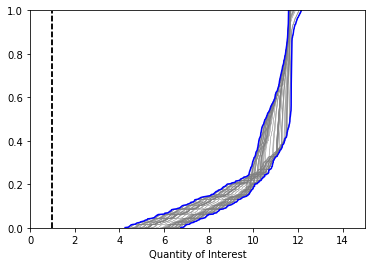

In [3]:
print(theHM.evalMetric([2, 3]))

upper, lower, CDFs = theHM.getHorsetail()
(q1, h1, t1) = upper
(q2, h2, t2) = lower

for CDF in CDFs:
    plt.plot(CDF[0], CDF[1], c='grey', lw=0.5)
plt.plot(q1, h1, 'b')
plt.plot(q2, h2, 'b')
plt.plot(t1, h1, 'k--')
plt.plot(t2, h2, 'k--')
plt.xlim([0, 15])
plt.ylim([0, 1])
plt.xlabel('Quantity of Interest')
plt.show()

Since this problem is highly non-linear, we obtain an interestingly shaped horsetail plot with CDFs that cross. Note that the target is plotted in dashed lines. Now to optimize the horsetail matching metric, we simply use the evalMetric method in an optimizer as before:

In [4]:
from scipy.optimize import minimize

solution = minimize(theHM.evalMetric, x0=[1,1], method='Nelder-Mead')
print(solution)

 final_simplex: (array([[-3.42108942e-05, -2.13933676e+01],
       [ 2.02055737e-07, -2.13933016e+01],
       [-4.81796145e-05, -2.13933251e+01]]), array([8.44599507, 8.44599507, 8.44599507]))
           fun: 8.445995069120176
       message: 'Optimization terminated successfully.'
          nfev: 143
           nit: 74
        status: 0
       success: True
             x: array([-3.42108942e-05, -2.13933676e+01])


Now we can inspect the horsetail plot of the optimum design by using the getHorsetail method again:

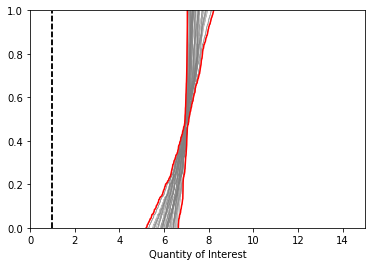

In [5]:
upper, lower, CDFs = theHM.getHorsetail()

for CDF in CDFs:
    plt.plot(CDF[0], CDF[1], c='grey', lw=0.5)
plt.plot(upper[0], upper[1], 'r')
plt.plot(lower[0], lower[1], 'r')
plt.plot([theHM.ftarget[0](y) for y in upper[1]], upper[1], 'k--')
plt.plot([theHM.ftarget[1](y) for y in lower[1]], lower[1], 'k--')
plt.xlim([0, 15])
plt.ylim([0, 1])
plt.xlabel('Quantity of Interest')
plt.show()

You may have noticed that the optimization required a large number of evaluations to converge, and so takes some time to run. In the next notebook we will show how to utilize gradients to speed up the optimization: http://nbviewer.jupyter.org/github/lwcook/horsetail-matching/blob/master/notebooks/Gradients.ipynb

For other tutorials, please visit http://www-edc.eng.cam.ac.uk/aerotools/horsetailmatching/